# Gathering Real Distribution Data

In [ ]:
from QAOA_simulator import QAOA_run, get_simulator
import networkx as nx
import qokit.maxcut as mc
import numpy as np
import matplotlib.pyplot as plt

N = 6
p = 1

G = nx.erdos_renyi_graph(N, 0.5)
ising_model = mc.get_maxcut_terms(G)
sim = get_simulator(N, ising_model)
init_gamma, init_beta = np.random.rand(2, p)
# Get the costs using QOKit (can benefit from GPU acceleration)
costs = sim.get_cost_diagonal()

unique_costs, cost_counts = np.unique(costs, return_counts=True)
cost_probabilities = cost_counts / 2**N

print(f"Costs: {costs}")
print(f"# Unique Costs: {unique_costs}")
print(f"Cost Counts: {cost_counts}")
print(f"Cost Probabilities: {cost_probabilities}")


# Let's Recreate FIG 2
From the parameter setting heuristic paper

In [ ]:
from QAOA_simulator import QAOA_run, get_simulator
import networkx as nx
import qokit.maxcut as mc
import numpy as np
import matplotlib.pyplot as plt

def get_real_distributions(graphs, N):
    max_num_edges = N*(N-1) // 2
    
    num_graphs = len(graphs)
    num_possible_bitstrings = 2**N
    num_possible_costs = max_num_edges+1
    max_hamming_distance = N

    # This could be a lot more efficient

    all_costs = np.zeros((num_graphs, num_possible_bitstrings))
    real_distributions = np.zeros((num_graphs, num_possible_bitstrings, max_hamming_distance+1, num_possible_costs))
    for (i, G) in enumerate(graphs):
        ising_model = mc.get_maxcut_terms(G)
        sim = get_simulator(N, ising_model)
        # Get the costs using QOKit (can benefit from GPU acceleration)
        costs = sim.get_cost_diagonal()
        all_costs[i,:] = costs

        # Loop over the possible bitstrings
        for x in range(num_possible_bitstrings):
            for y in range(num_possible_bitstrings):
                # Compute hamming distance
                xor = x ^ y 
                d = xor.bit_count()
                cost_y = int(costs[y])
                real_distributions[i, x, d, cost_y] += 1

    return all_costs, real_distributions

def get_homogeneous_distribution(all_costs, real_distribution_ary):
    N_costs = real_distribution_ary.shape[3]
    N_distances = real_distribution_ary.shape[2]
    homogeneous_distribution = np.zeros((N_costs, N_distances, N_costs))
    N_cost_occurences = np.zeros(N_costs)

    # Sum n over all bitstrings with cost c'
    for (graph_i, bitstring_i, distance_i, cost_i) in np.ndindex(real_distribution_ary.shape):
        cost_x = int(all_costs[graph_i, bitstring_i])
        N_cost_occurences[cost_x] += 1
        homogeneous_distribution[cost_x, distance_i, cost_i] += real_distribution_ary[graph_i, bitstring_i, distance_i, cost_i]

    # Divide by number of bitstrings for which c(x) = c'
    for cost_x in range(N_costs):
        if N_cost_occurences[cost_x] != 0:
            homogeneous_distribution[cost_x, :, :] /= N_cost_occurences[cost_x]


    

    return homogeneous_distribution

def heatmap_real_distribution(real_distribution, bitstring):
    plt.imshow(real_distribution[bitstring,:,:])
    plt.xlabel("Cost")
    plt.ylabel("Hamming Distance")
    plt.title(f"n(x; d, c), x={bin(bitstring)}")
    plt.show()



In [ ]:
N = 3
P = 1
G = nx.erdos_renyi_graph(N, P, seed=1)
nx.draw(G, with_labels=True)
all_costs, real_distribution = get_real_distributions([G], N)
#print(real_distribution.shape)
#print(real_distribution[0,:,:,:])
for i in range(real_distribution.shape[1]):
    print(f"Bitstring: {bin(i)}")
    print(real_distribution[0,i,:,:])

# Generating Graphs, Distributions

In [58]:
N = 10
P = 1/3
N_random_graphs = 30
random_graphs = [nx.erdos_renyi_graph(N, P, seed=i) for i in range(N_random_graphs)]
all_costs, real_distributions = get_real_distributions(random_graphs, N)

homogeneous_distribution = get_homogeneous_distribution(all_costs, real_distributions)

individual_homogeneous_distributions = []
for i in range(N_random_graphs):
    single_real_distribution = real_distributions[i,:,:,:]
    new_shape = (-1,) + single_real_distribution.shape
    single_costs = np.reshape(all_costs[i,:], (1, -1))
    single_real_distribution = np.reshape(single_real_distribution, new_shape)
    individual_homogeneous_distributions.append(get_homogeneous_distribution(single_costs, single_real_distribution))

all_homogeneous_distributions_ary = np.stack(individual_homogeneous_distributions)
avg_homogeneous_distribution = np.mean(all_homogeneous_distributions_ary, axis=0)
stddev_homogeneous_distribution = np.std(all_homogeneous_distributions_ary, axis=0)
avg_stddev_homogeneous_distribution = stddev_homogeneous_distribution / avg_homogeneous_distribution 

/tmp/ipykernel_123702/2405959544.py:20: RuntimeWarning: invalid value encountered in divide
  avg_stddev_homogeneous_distribution = stddev_homogeneous_distribution / avg_homogeneous_distribution


# Homogeneous Displays

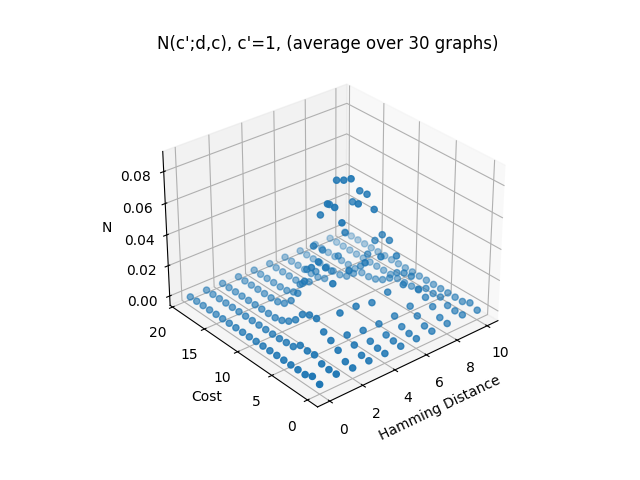

In [67]:

import matplotlib
import matplotlib.pyplot as plt 
from plot_utils import plot_3d_scatter
%matplotlib widget 
#%matplotlib inline

#heatmap_real_distribution(real_distribution[0,:,:,:], 0)

xs = np.arange(real_distributions.shape[2])
ys = np.arange(real_distributions.shape[3])[0:20]
graph_index = 0
cost = 1
plot_3d_scatter(xs, ys, homogeneous_distribution[cost,:,:], f"N(c';d,c), c'={cost}, (average over {N_random_graphs} graphs)", "Hamming Distance", "Cost", "N")
plt.show()

#stddev_avg_real_distribution = np.std(real_distribution, axis=0) / avg_real_distribution
##plot_3d_scatter(xs, ys, stddev_avg_real_distribution[7,:,:], f"stddev/avg n(x;d,c), x={bin(bitstring)}, C={bitstring_cost}, (average over {N_random_graphs} graphs)", "Hamming Distance", "Cost", "Stddev / Avg")
#fig = plt.figure()
#ax = fig.add_subplot()
#im = ax.imshow(stddev_avg_real_distribution[7,:,:20], origin="lower")
#fig.colorbar(im, ax=ax)
#ax.set_title(f"stddev/avg n(x;d,c), x={bin(bitstring)}, C={bitstring_cost}, (average over {N_random_graphs} graphs)")
#ax.set_xlabel("Hamming Distance")
#ax.set_ylabel("Cost")


# Real Visualitzations

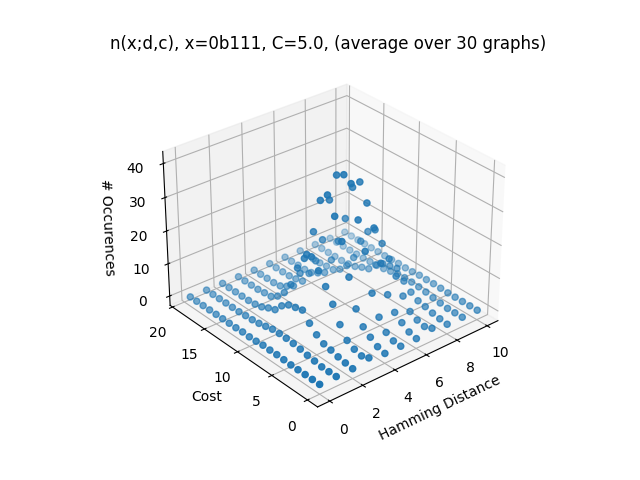

Text(0, 0.5, 'Cost')

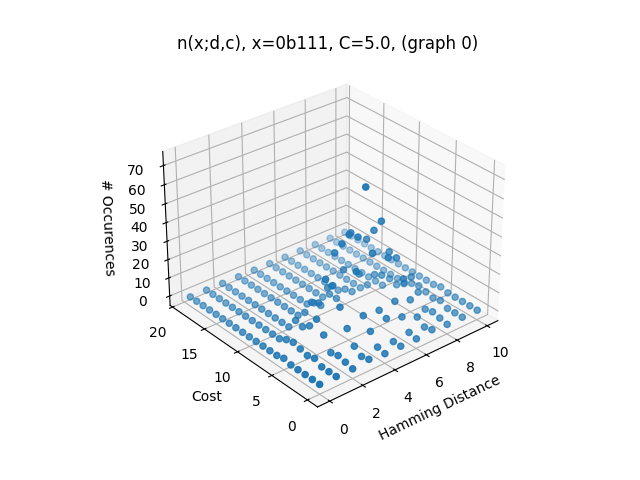

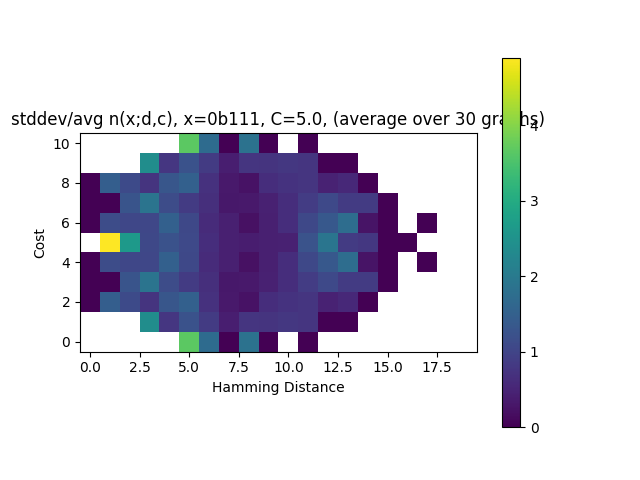

In [69]:
import matplotlib
import matplotlib.pyplot as plt 
from plot_utils import plot_3d_scatter
%matplotlib widget 
#%matplotlib inline

#heatmap_real_distribution(real_distribution[0,:,:,:], 0)

xs = np.arange(real_distributions.shape[2])
ys = np.arange(real_distributions.shape[3])[0:20]
graph_index = 0
bitstring = 7
bitstring_cost = all_costs[graph_index, bitstring]
plot_3d_scatter(xs, ys, real_distributions[graph_index, bitstring, :, :], f"n(x;d,c), x={bin(bitstring)}, C={bitstring_cost}, (graph {graph_index})", "Hamming Distance", "Cost", "# Occurences")

avg_real_distribution = np.mean(real_distributions, axis=0)
plot_3d_scatter(xs, ys, avg_real_distribution[bitstring,:,:], f"n(x;d,c), x={bin(bitstring)}, C={bitstring_cost}, (average over {N_random_graphs} graphs)", "Hamming Distance", "Cost", "# Occurences")
plt.show()

#plot_3d_scatter(xs, ys, stddev_avg_real_distribution[7,:,:], f"stddev/avg n(x;d,c), x={bin(bitstring)}, C={bitstring_cost}, (average over {N_random_graphs} graphs)", "Hamming Distance", "Cost", "Stddev / Avg")
fig = plt.figure()
ax = fig.add_subplot()
im = ax.imshow(stddev_avg_real_distribution[bitstring,:,:20], origin="lower")
fig.colorbar(im, ax=ax)
ax.set_title(f"stddev/avg n(x;d,c), x={bin(bitstring)}, C={bitstring_cost}, (average over {N_random_graphs} graphs)")
ax.set_xlabel("Hamming Distance")
ax.set_ylabel("Cost")


# StdDev / Average (Fig 2)
### Real Version

/tmp/ipykernel_123702/4055232905.py:2: RuntimeWarning: invalid value encountered in divide
  stddev_avg_real_distribution = np.std(real_distribution, axis=0) / avg_real_distribution


Text(0, 0.5, 'Hamming Distance')

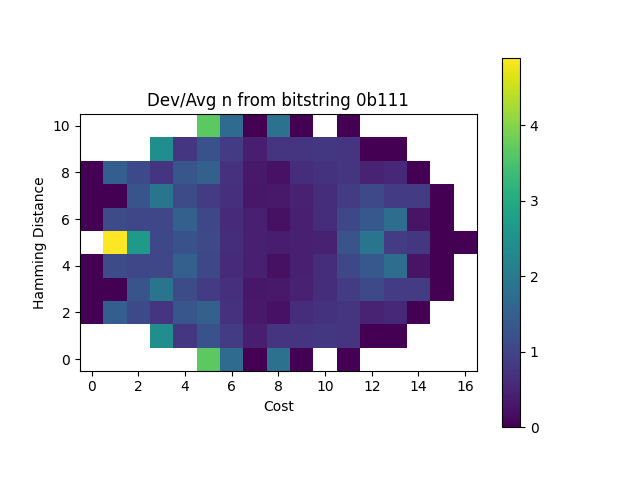

In [72]:
avg_real_distribution = np.mean(real_distributions, axis=0)
stddev_avg_real_distribution = np.std(real_distribution, axis=0) / avg_real_distribution

bitstring = 7

#print(avg_stddev_homogeneous_distribution[7,:17,:11])
fig = plt.figure()
ax = fig.add_subplot()
im = ax.imshow(stddev_avg_real_distribution[bitstring,:11,:17], origin="lower")
fig.colorbar(im, ax=ax)
ax.set_title(f"Dev/Avg n from bitstring {bin(bitstring)}")
ax.set_xlabel("Cost")
ax.set_ylabel("Hamming Distance")


### Homogeneous Version